## Transmitter Code

In [41]:
# Import all needed modules

import numpy as np
import scipy

from matplotlib import pyplot as plt
import random

from ldpc_jossy.py import ldpc # LDPC from Jossy

In [31]:
# Define OFDM parameters:

symbol_length = 1024
cyclic_length = 32

In [ ]:
# Start LDPC Object:

c = ldpc.code("802.11n", '1/2', 4)

01000001011000110110001101101111011100100110010001101001011011100110011100100000011101000110111100100000011000010110110001101100


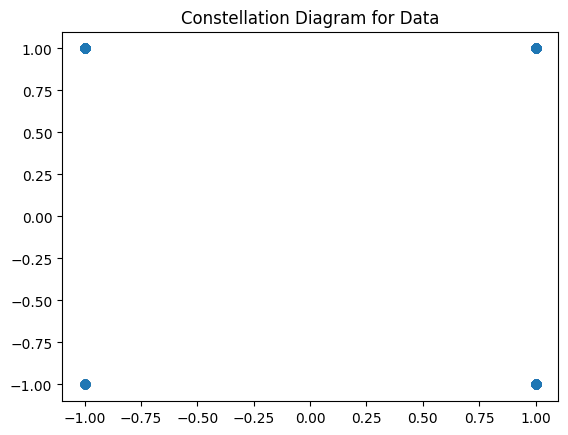

In [32]:
# OPEN FILE TO TRANSMIT

with open('transmitter/data_file.txt', 'r') as file:
    data = file.read().replace('\n', '')

binary_data = ''.join(format(ord(x), 'b').zfill(8) for x in data)

print(binary_data[0:128])

# LDPC ENCODING

### TODO

# PAD WITH 0s

split_length = symbol_length - 2 # (symbol_length - 2) as need 511 constellation 'stars' per symbol, and each 'star' represents 2 bits.

for i in range(split_length - (len(binary_data) % split_length)): 
    binary_data += "0"

assert len(binary_data) % split_length == 0.0

# ENCODE WITH GRAY CODE

to_encode = [binary_data[i:i+2] for i in range(0, len(binary_data), 2)] # Split into list of two characters elements

gray_code = 1j * np.arange(len(to_encode)) # 'empty' array

for index, i in enumerate(to_encode):
    if i == "00":
        gray_code[index] = 1 + 1j
    elif i == "01":
        gray_code[index] = -1 + 1j
    elif i == "11":
        gray_code[index] = -1 - 1j
    elif i == "10":
        gray_code[index] = 1 - 1j
    else:
        raise Exception("Gray code mapping error")

plt.scatter(gray_code[0:500].real, gray_code[0:500].imag)
plt.title("Constellation Diagram for Data")
plt.show()

# gray_code is one list of all the gray code points

In [33]:
symbols = np.split(np.array(gray_code), len(gray_code) / (split_length / 2))

# ENFORCE CONJUGATE SYMMETRY:

for index, x in enumerate(symbols):
    conj = np.conjugate(x)[::-1]
    symbols[index] = np.concatenate((x, conj), axis=None)

    symbols[index] = np.insert(symbols[index], 0, 0)
    symbols[index] = np.insert(symbols[index], int(symbol_length / 2), 0)

# Inverse DFT

info = np.fft.ifft(symbols)

for i in info[15]:
    assert i.imag == 0 # Check is now real

# ADD CYCLIC PREFIXES

to_transmit = np.zeros(shape = (len(info), symbol_length + cyclic_length))

for index, x in enumerate(info):
    cyclic_prefix = x[-32:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit[index] = new_x

print(to_transmit.shape) # Should be (319 - or alternate length, 1056)

to_transmit = np.concatenate(to_transmit, axis = 0)

print(to_transmit.shape)

(377, 1056)
(398112,)


/var/folders/10/m2d64f1s1kx01s59h9vnf84w0000gn/T/ipykernel_37127/757841710.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index] = new_x


## Channel Simulation

In [34]:
# CHANNEL FILTER

channel_response = np.loadtxt('weekend_files/channel.csv', delimiter = ",", dtype = "float")

to_decode = np.convolve(channel_response, to_transmit)

to_decode = to_decode[:-1 * len(channel_response) + 1]

# NOISE

for index, i in enumerate(to_decode):
    to_decode[index] = i + random.uniform(-0.01, 0.01)

np.savetxt("max_test_out.csv", to_decode, delimiter = ",")


## Decoder

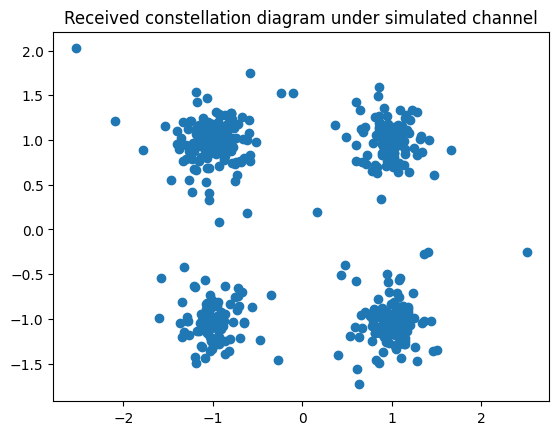

In [35]:
decoded_symbols = np.split(to_decode, len(to_decode) / (symbol_length + cyclic_length))

# Remove Cyclic Prefix

for index, i in enumerate(decoded_symbols):
    decoded_symbols[index] = i[cyclic_length:]

# DFT each symbol:

symbols_freq = np.zeros((len(decoded_symbols), symbol_length)).astype(complex) # 'empty' array

for index, i in enumerate(decoded_symbols):
    symbols_freq[index] = np.fft.fft(i)

assert symbols_freq.shape[1] == symbol_length

channel_response = np.pad(channel_response, (0, symbol_length - len(channel_response)))
channel_freq = np.fft.fft(channel_response)

# Divide by DFT of Channel Response:

recieved_freq = symbols_freq / channel_freq

constellations = np.zeros((1, 511))

for index, i in enumerate(recieved_freq):
    constellations = np.vstack((constellations, i[1:512]))

plt.scatter(constellations[-10].real, constellations[-10].imag)
plt.title("Received constellation diagram under simulated channel")
plt.show()


In [36]:
decoded_binary = []

# Do Inverse Gray Code:

for symbol in constellations:
    for i in symbol:
        if np.real(i) >= 0 and np.imag(i) >= 0:
            decoded_binary.append("00")
        elif np.real(i) <= 0 and np.imag(i) >= 0:
            decoded_binary.append("01")
        elif np.real(i) <= 0 and np.imag(i) <= 0:
            decoded_binary.append("11")
        elif np.real(i) >= 0 and np.imag(i) <= 0:
            decoded_binary.append("10")
        else:
            raise Exception("Gray Code Decoding Error")

# LDPC DECODING

### TODO

# CONVERT BINARY TO ASCII

# Split into 7 bit sections:

decoded_text = ''

ascii = [int(binary_data[i:i+8], 2) for i in range(0, len(binary_data), 8)]
decoded_text = ''.join(chr(i) for i in ascii)

print(decoded_text[0:100])

According to all known laws of aviation, there is no way a bee should be able to fly.Its wings are t
